In [1]:
import os
import glob

from tqdm import trange
import random
import math

from dateutil import parser
from datetime import datetime
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
config = {
  "plots": {
        "show_plots": False,
        "xticks_interval": 1200,
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_test": "#FF4136",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "data": {
        "window_size": 10,
        "train_split_size": 0.80,
    }, 
    "model_MO": {
        "input_size": 1, # since we are only using 1 feature, price
        "num_lstm_layers": 5,
        "lstm_size": 16,
        "dropout": 0.25,
        "output_size": 1,
    },
    "training_MO": {
        "batch_size": 1,
        "num_epoch": 50,
        "learning_rate": 0.005,
        "scheduler_step_size": 10,
    },
    "model_MM": {
        "input_size": 1, # since we are only using 1 feature, price
        "num_lstm_layers": 5,
        "lstm_size": 16,
        "dropout": 0.4,
        "target_len": 60,
        "stride": 1,
        "patience": 5, # number of epochs to wait for Early Stopping
    },
    "training_MM": {
        "batch_size": 256,
        "num_epoch": 15,
        "learning_rate": 0.004,
        "scheduler_step_size": 10,
    },
    "paths": {
        "drive": {
            "agg_trade": {
                "train": "/content/drive/MyDrive/IP/Repos/HFTransformer/input_data/",
                "test": "/content/drive/MyDrive/IP/Repos/HFTransformer/input_data/", 
            },
            "orderbook": {
                "train": "/content/drive/MyDrive/IP/Repos/LSTM_Transformer/input_data/orderbook_clean.csv",
                "test": "/content/drive/MyDrive/IP/Repos/LSTM_Transformer/input_data/orderbook_test_clean.csv",
            },
            "models": "/content/drive/MyDrive/IP/Repos/LSTM_Transformer/models/",
            "figures": "/content/drive/MyDrive/IP/Repos/LSTM_Transformer/figures/",
        },
        "local": {
            "agg_trade": {
                "train": "./input_data/",
                "test": "./input_data/", 
            },
            "orderbook": {
                "train": "./input_data/orderbook_clean.csv",
                "test": "./input_data/orderbook_test_clean.csv",
            },
            "models": "./models/",
            "figures": "./figures",
        }
    }
}

## Data preparation

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
drive = False
device

'cuda'

In [4]:
#from google.colab import drive
#drive.mount('/content/drive')

In [5]:
date_train = 'All_to_Sept' 
date_test = 'All_to_Sept'
drive = None
if drive:
    agg_trade = pd.read_csv(config["paths"]["drive"]["agg_trade"]["train"]+date_train+'/orderbook.csv')    
else:
    agg_trade = pd.read_csv(config["paths"]["local"]["agg_trade"]["train"]+date_train+'/orderbook_agg_trade_dollarvol.csv')
    agg_trade_test = pd.read_csv(config["paths"]["local"]["agg_trade"]["test"]+date_test+'/orderbook_agg_trade_dollarvol.csv')

#agg_trade['price'] = agg_trade['w_midprice']

## Preparing Data for LSTM MO

In [6]:
def prepare_data_x(data, window_size, lag):
    '''
    Windows the input data for the ML models.
    '''
    n_row = data.shape[0] - window_size + 1
    subset = data[:window_size]
    subset_mean = np.mean(subset, axis=0)
    output = np.zeros([n_row, window_size, len(subset_mean)])
    x_mean = np.zeros([n_row, len(subset_mean)])
    x_std = np.zeros([n_row, len(subset_mean)])
    for idx in range(n_row):
        subset = data[idx:idx+window_size]
        subset_mean = np.mean(subset, axis=0)
        subset_std = np.std(subset, axis=0) + 0.01
        subset_norm = (subset-subset_mean)/subset_std
        x_mean[idx,:] = subset_mean
        x_std[idx,:] = subset_std
        output[idx,:,:] = subset_norm
    x_mean = np.array(x_mean)
    x_std = np.array(x_std)
    return output[:-lag-1], output[-1], x_mean, x_std

def prepare_data_y(x, window_size, lag):
    '''
    Windows the target data for the ML models.
    '''
    output = np.zeros([len(x)-window_size-lag])
    std = 1.1*np.sqrt(lag)+lag*0.01
    for idx in range(0,len(x)-window_size-lag):
        output[idx] = np.log(x[window_size+lag-1+idx,0]/x[window_size-1+idx,0])*10_000
    output = output/std
    return output

def prepare_data(normalized_prices_train, dates_train, normalized_prices_test, dates_test, config, lag=1, plot=False):
    '''
    Returns input and target data.
    '''
    data_x, data_x_unseen, x_mean, x_std = prepare_data_x(normalized_prices_train, window_size=config["data"]["window_size"], lag=lag)
    data_y = prepare_data_y(normalized_prices_train, window_size=config["data"]["window_size"], lag=lag)

    split_index = int(data_y.shape[0]*config["data"]["train_split_size"])
    data_x_train = data_x[:split_index]
    data_x_val = data_x[split_index:]
    data_y_train = data_y[:split_index]
    data_y_val = data_y[split_index:]

    return split_index, data_x_train, data_y_train, data_x_val, data_y_val

## Preparing Data for LSTM MM

In [7]:
# The following helper functions and models were based on existing code: https://github.com/lkulowski/LSTM_encoder_decoder

def train_test_split(datetime, price, split = 0.8):
  '''
  Splits time series into train/test sets.
  '''  
  datetime = np.array(datetime)
  price = np.array(price)
  
  indx_split = int(split * len(price))
  indx_train = np.arange(0, indx_split, dtype=int)
  indx_val = np.arange(indx_split, len(price), dtype=int)
    
  t_train = datetime[indx_train]
  y_train = price[indx_train]
  y_train = y_train.reshape(-1, 1)
  
  t_val = datetime[indx_val]
  y_val = price[indx_val]
  y_val = y_val.reshape(-1, 1)
  
  return t_train, y_train, t_val, y_val 


def windowed_dataset(y, input_window = 5, output_window = 1, stride = 1, num_features = 1):
    '''
    Creates a windowed dataset.
    '''
    L = y.shape[0]
    num_samples = (L - input_window - output_window) // stride + 1

    X = np.zeros([input_window, num_samples, num_features])
    Y = np.zeros([output_window, num_samples, num_features])    
    
    for ff in np.arange(num_features):
        for ii in np.arange(num_samples):
            start_x = stride * ii
            end_x = start_x + input_window
            X[:, ii, ff] = y[start_x:end_x, ff]

            start_y = stride * ii + input_window
            end_y = start_y + output_window 
            Y[:, ii, ff] = y[start_y:end_y, ff]

    return X, Y


def numpy_to_torch(x_train, y_train, x_validation, y_validation, device):
    '''
    Converts numpy array to PyTorch tensor.
    '''
    x_train_torch = torch.from_numpy(x_train).type(torch.Tensor).to(device)
    y_train_torch = torch.from_numpy(y_train).type(torch.Tensor).to(device)

    x_test_torch = torch.from_numpy(x_validation).type(torch.Tensor).to(device)
    y_test_torch = torch.from_numpy(y_validation).type(torch.Tensor).to(device)
    
    return x_train_torch, y_train_torch, x_test_torch, y_test_torch

## Defining the Many-to-One LSTM model

In [8]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

In [9]:
class LSTM_MO(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.prelu = nn.PReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)
        
        self.init_weights()


    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                 nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                 nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                 nn.init.orthogonal_(param)


    def forward(self, x):
        batchsize = x.shape[0]
        x = self.linear_1(x)
        x = self.prelu(x)
        lstm_out, (h_n, c_n) = self.lstm(x)
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1) 
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:,-1]


    def train_model(self, train_dataloader, val_dataloader, learning_rate, scheduler_step_size, n_epochs=50, device="cpu", save_path=None, forecast_window=None):
      
        def run_epoch(dataloader, is_training=False):
            epoch_loss = 0
            outputs = torch.Tensor(0).to(device)
            targets = torch.Tensor(0).to(device)
            if is_training:
                self.train()
            else:
                self.eval()
            for idx, (x, y) in enumerate(dataloader):
                if is_training:
                    optimizer.zero_grad()

                batchsize = x.shape[0]
                x = x.to(device)
                y = y.to(device)
                out = self.forward(x)
                loss = criterion(out.contiguous(), y.contiguous())

                if is_training:
                    loss.backward()
                    optimizer.step()
                
                if not is_training:
                    outputs = torch.cat((outputs.contiguous(), out))
                    targets = torch.cat((targets, y.contiguous()))
                    
                epoch_loss += (loss.detach().item() / batchsize)
                
            lr = scheduler.get_last_lr()[0]
            if not is_training:
                print(outputs.cpu().detach().numpy())
                print(targets.cpu().detach().numpy())
                plt.plot(targets.cpu().detach().numpy(), alpha=0.3)
                plt.plot(outputs.cpu().detach().numpy())
                plt.show()
                r2 = r2_score(targets.cpu().detach().numpy(), outputs.cpu().detach().numpy())
                return epoch_loss, lr, r2
            else:
                return epoch_loss, lr

      
        # define optimizer, scheduler and loss function
        criterion = nn.MSELoss(reduction='sum')
        optimizer = optim.AdamW(model_MO.parameters(), lr=learning_rate, betas=(0.9, 0.98), eps=1e-9)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=0.995)

        # begin training
        for epoch in range(n_epochs):
            loss_train, lr_train = run_epoch(train_dataloader, is_training=True)
            loss_val, lr_val, r2 = run_epoch(val_dataloader)
            scheduler.step()

            if save_path:
                results = {
                        'model': 'LSTM_MO',
                        'pred_len': forecast_window,
                        'epoch': epoch,
                        'train_loss': loss_train,
                        'val_loss': loss_val,
                        'r2_val_sklearn': r2            
                }

                df = pd.DataFrame([results])
                df.to_csv(save_path, mode='a', header=not os.path.exists(save_path), index=False)

            
            print('Epoch[{}/{}] | loss train:{:.6f}, val loss:{:.6f} | lr:{:.6f} | r2: {:.5f}|'
                      .format(epoch+1, n_epochs, loss_train, loss_val, lr_train, r2))

## Defining the Many-to-Many LSTM Model

In [10]:
class lstm_encoder(nn.Module):
    ''' Encodes time-series sequence '''

    def __init__(self, input_size, hidden_size, dropout = 0.1, num_layers = 1):
        super(lstm_encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # define LSTM layer
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                            num_layers = num_layers, dropout = dropout)

    def forward(self, x_input):
        lstm_out, self.hidden = self.lstm(x_input.view(x_input.shape[0], x_input.shape[1], self.input_size))
        
        return lstm_out, self.hidden     
    
    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size),
                torch.zeros(self.num_layers, batch_size, self.hidden_size))


class lstm_decoder(nn.Module):
    ''' Decodes hidden state output by encoder '''
    
    def __init__(self, input_size, hidden_size, dropout = 0.1, num_layers = 1):
        super(lstm_decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                            num_layers = num_layers, dropout = dropout)
        self.PReLU = nn.PReLU()
        self.batchnorm = nn.BatchNorm1d(hidden_size)
        self.linear = nn.Linear(hidden_size, input_size)           

    def forward(self, x_input, encoder_hidden_states):
        lstm_out, self.hidden = self.lstm(x_input.unsqueeze(0), encoder_hidden_states)
        output = self.PReLU(lstm_out.squeeze(0))
        #output = self.batchnorm(output)
        output = self.linear(output)     
        
        return output, self.hidden

class LSTM_MM(nn.Module):
    ''' train LSTM encoder-decoder and make predictions '''
    
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(LSTM_MM, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = lstm_encoder(input_size = input_size, hidden_size = hidden_size, num_layers=num_layers, dropout=dropout)
        self.decoder = lstm_decoder(input_size = input_size, hidden_size = hidden_size, num_layers=num_layers, dropout=dropout)


    def train_model(self, input_tensor_train, target_tensor_train, input_tensor_val, target_tensor_val, n_epochs, target_len,
                    batch_size,device, training_prediction = 'recursive', teacher_forcing_ratio = 0.5, learning_rate = 0.01, dynamic_tf = False):
        '''
        train lstm encoder-decoder
        '''

        # initialize array of losses 
        losses_train = np.full(n_epochs, np.nan)
        losses_val = np.full(n_epochs, np.nan)

        optimizer = optim.Adam(self.parameters(), lr = learning_rate)
        criterion = nn.MSELoss()

        # calculate number of batch iterations
        n_batches_train = int(input_tensor_train.shape[1] / batch_size)
        n_batches_val = int(input_tensor_val.shape[1] / batch_size)

        with trange(n_epochs) as tr:
            for it in tr:
                self.train()
                batch_loss = 0.

                for b in range(n_batches_train):
                    # select data 
                    input_batch = input_tensor_train[:, b: b + batch_size, :]
                    target_batch = target_tensor_train[:, b: b + batch_size, :]
                    # outputs tensor
                    outputs = torch.zeros(target_len, batch_size, input_batch.shape[2])
                    # initialize hidden state
                    encoder_hidden = self.encoder.init_hidden(batch_size)
                    # zero the gradient
                    optimizer.zero_grad()
                    # encoder outputs
                    encoder_output, encoder_hidden = self.encoder(input_batch)
                    # decoder with teacher forcing
                    decoder_input = input_batch[-1, :, :]   # shape: (batch_size, input_size)
                    decoder_hidden = encoder_hidden

                    if training_prediction == 'recursive':
                        # predict recursively
                        for t in range(target_len): 
                            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                            outputs[t] = decoder_output
                            decoder_input = decoder_output

                    if training_prediction == 'teacher_forcing':
                        # use teacher forcing
                        if random.random() < teacher_forcing_ratio:
                            for t in range(target_len): 
                                decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                                outputs[t] = decoder_output
                                decoder_input = target_batch[t, :, :]

                        # predict recursively 
                        else:
                            for t in range(target_len): 
                                decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                                outputs[t] = decoder_output
                                decoder_input = decoder_output

                    if training_prediction == 'mixed_teacher_forcing':
                        # predict using mixed teacher forcing
                        for t in range(target_len):
                            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                            outputs[t] = decoder_output
                            
                            # predict with teacher forcing
                            if random.random() < teacher_forcing_ratio:
                                decoder_input = target_batch[t, :, :]
                            
                            # predict recursively 
                            else:
                                decoder_input = decoder_output

                    # compute the loss 
                    loss = criterion(outputs.to(device), target_batch.to(device))
                    batch_loss += loss.item()
                    
                    # backpropagation
                    loss.backward()
                    optimizer.step()

                # loss for epoch 
                batch_loss /= n_batches_train
                batch_loss = math.sqrt(batch_loss) 
                losses_train[it] = batch_loss

                #validation
                self.eval()                
                batch_loss_val = 0.

                for b in range(n_batches_val):
                    # select data 
                    input_batch = input_tensor_val[:, b: b + batch_size, :]
                    target_batch = target_tensor_val[:, b: b + batch_size, :]
                    # outputs tensor
                    outputs = torch.zeros(target_len, batch_size, input_batch.shape[2])
                    # initialize hidden state
                    encoder_hidden = self.encoder.init_hidden(batch_size)
                    # encoder outputs
                    encoder_output, encoder_hidden = self.encoder(input_batch)
                    # decoder with teacher forcing
                    decoder_input = input_batch[-1, :, :]   # shape: (batch_size, input_size)
                    decoder_hidden = encoder_hidden

                    if training_prediction == 'recursive':
                        # predict recursively
                        for t in range(target_len): 
                            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                            outputs[t] = decoder_output
                            decoder_input = decoder_output

                    if training_prediction == 'teacher_forcing':
                        # use teacher forcing
                        if random.random() < teacher_forcing_ratio:
                            for t in range(target_len): 
                                decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                                outputs[t] = decoder_output
                                decoder_input = target_batch[t, :, :]

                        # predict recursively 
                        else:
                            for t in range(target_len): 
                                decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                                outputs[t] = decoder_output
                                decoder_input = decoder_output

                    if training_prediction == 'mixed_teacher_forcing':
                        # predict using mixed teacher forcing
                        for t in range(target_len):
                            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                            outputs[t] = decoder_output
                            
                            # predict with teacher forcing
                            if random.random() < teacher_forcing_ratio:
                                decoder_input = target_batch[t, :, :]
                            
                            # predict recursively 
                            else:
                                decoder_input = decoder_output

                    # compute the loss 
                    loss = criterion(outputs.to(device), target_batch.to(device))
                    batch_loss_val += loss.item()
                
                                # loss for epoch 
                    batch_loss_val /= n_batches_val
                    batch_loss_val = math.sqrt(batch_loss_val) 
                    losses_val[it] = batch_loss_val

                # dynamic teacher forcing
                if dynamic_tf and teacher_forcing_ratio > 0:
                    teacher_forcing_ratio = teacher_forcing_ratio - 0.02
                # progress bar 
                tr.set_postfix(train_loss="{0:.3f}".format(batch_loss),val_loss="{0:.3f}".format(batch_loss_val))
                    
        return losses_train, losses_val

    def predict(self, input_tensor, target_len):
        self.eval()

        # encode input_tensor
        input_tensor = input_tensor.unsqueeze(1)     # add in batch size of 1
        encoder_output, encoder_hidden = self.encoder(input_tensor)

        # initialize tensor for predictions
        outputs = torch.zeros(target_len, input_tensor.shape[2])

        # decode input_tensor
        decoder_input = input_tensor[-1, :, :]
        decoder_hidden = encoder_hidden
        
        for t in range(target_len):
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            outputs[t] = decoder_output.squeeze(0)
            decoder_input = decoder_output
            
        np_outputs = outputs.detach().numpy()
        
        return np_outputs

## Model training - Many to One

In [11]:
def augment_trade_data(df, lag=0, forecast_window=None):
    if forecast_window:
        df['lag_return'] = np.log(df['price'].shift(forecast_window)/df['price'].shift(forecast_window+1))
        return df.iloc[forecast_window+1:,:]
    if lag == 0:
        return df
    else:
        col_name = 'log_lag'+str(lag)+'_price'
        df[col_name] = np.log(df.price) - np.log(df.price).shift(lag)
        return df.iloc[lag:,:]

In [ ]:
save_path = os.path.join('/home/gaen/Documents/codespace-gaen/Ts-master/playground_models/lstm_original',
                            str(int(time.time()))+'_results.csv')

forecast_windows = [i for i in range(1,31)]
#forecast_windows = [1:31]

for lag in forecast_windows:
    orderbook = augment_trade_data(agg_trade, forecast_window=lag)

    features = ['price', 'lag_return',
                'bid1', 'bidqty1', 'bid2', 'bidqty2', 'bid3', 'bidqty3', 'bid4', 'bidqty4', 'bid5', 'bidqty5',
                'bid6', 'bidqty6', 'bid7', 'bidqty7', 'bid8', 'bidqty8', 'bid9', 'bidqty9', 'bid10', 'bidqty10',
                'ask1', 'askqty1', 'ask2', 'askqty2', 'ask3', 'askqty3', 'ask4', 'askqty4', 'ask5', 'askqty5',
                'ask6', 'askqty6', 'ask7', 'askqty7', 'ask8', 'askqty8', 'ask9', 'askqty9', 'bid10', 'bidqty10']

    split_index, data_x_train, data_y_train, data_x_val, data_y_val = prepare_data(np.array(orderbook[features][1_000_000:2_720_000]),
                                                                                                                            np.array(agg_trade.datetime[2_005_000:2_006_000]),
                                                                                                                            np.array(orderbook[features][60_000:60_600]),
                                                                                                                            np.array(agg_trade.datetime[60_000:60_600]),
                                                                                                                            config, lag=lag, plot=False)


    dataset_train = TimeSeriesDataset(data_x_train, data_y_train)
    dataset_val = TimeSeriesDataset(data_x_val, data_y_val)

    print("Train data shape", dataset_train.x.shape, dataset_train.y.shape)
    print("Validation data shape", dataset_val.x.shape, dataset_val.y.shape)
    # print("Test data shape", dataset_test.x.shape, dataset_test.y.shape)


    model_MO = LSTM_MO(input_size=len(features), hidden_layer_size=64,
                    num_layers=2, output_size=config["model_MO"]["output_size"], dropout=0.2)

    model_MO = model_MO.to(device)

    # create DataLoader
    train_dataloader = DataLoader(dataset_train, batch_size=config["training_MO"]["batch_size"], shuffle=False)
    val_dataloader = DataLoader(dataset_val, batch_size=config["training_MO"]["batch_size"], shuffle=False)

    model_MO.train_model(train_dataloader=train_dataloader, val_dataloader=val_dataloader, learning_rate=0.001,
                scheduler_step_size=config["training_MO"]["scheduler_step_size"], n_epochs=10,
                device='cuda', save_path=save_path, forecast_window=lag)

    # date_now = datetime.now()
    # timestamp = date_now.strftime("%d-%b-%Y_%H:%M:%S.%f")
    del data_x_train 
    del data_y_train
    del data_x_val
    del data_y_val

    torch.save(model_MO, f'/home/gaen/Documents/codespace-gaen/Ts-master/playground_models/lstm/No.1/LSTM_MO_LAG_{lag}.pt')

Train data shape (1375991, 10, 42) (1375991,)
Validation data shape (343998, 10, 42) (343998,)


In [1]:
plt.hist(np.random.normal(size = len(data_y_train)*3), bins=150, alpha=0.5)
plt.hist(data_y_train, bins=150, alpha=0.7)

NameError: name 'plt' is not defined

In [ ]:
np.std(data_y_train)

1.087750500704166

In [ ]:
lags = [i for i in range(31)]

orderbook = augment_trade_data(agg_trade, forecast_window=lag)
means = []
stds = []

for lag in lags:
    split_index, data_x_train, data_y_train, data_x_val, data_y_val, data_x_unseen, data_x_test, data_y_test = prepare_data(np.array(orderbook[['price','bid1']][1_200_000:2_200_000]),
                                                                                                                        np.array(agg_trade.datetime[2_000_000:2_100_000]),
                                                                                                                        np.array(orderbook[['price','bid1']][60_000:65_000]),
                                                                                                                        np.array(agg_trade.datetime[60_000:65_000]),
                                                                                                                        config, lag=lag, plot=False)
    mean = np.mean(data_y_train)
    std =  np.std(data_y_train)
    means.append(mean) 
    stds.append(std)             
    print(f'mean for lag {lag} {mean}')
    print(f'std for lag {lag} {std}')

(999900, 100, 2)
(999900,)
mean for lag 0 0.0
std for lag 0 0.0
(999899, 100, 2)
(999899,)
mean for lag 1 -0.002052977139672308
std for lag 1 1.0858796465521126
(999898, 100, 2)
(999898,)
mean for lag 2 -0.00410467584064107
std for lag 2 1.556017011973598
(999897, 100, 2)
(999897,)
mean for lag 3 -0.006154055526544967
std for lag 3 1.9217677462946574
(999896, 100, 2)
(999896,)
mean for lag 4 -0.008209040207585516
std for lag 4 2.228366158793651
(999895, 100, 2)
(999895,)
mean for lag 5 -0.010265174427752983
std for lag 5 2.4953964400714703
(999894, 100, 2)
(999894,)
mean for lag 6 -0.012325079093808363
std for lag 6 2.7358125435737817
(999893, 100, 2)
(999893,)
mean for lag 7 -0.014386081809158619
std for lag 7 2.9571307584237307
(999892, 100, 2)
(999892,)
mean for lag 8 -0.01644461902502651
std for lag 8 3.162067860737714
(999891, 100, 2)
(999891,)
mean for lag 9 -0.01850095315869017
std for lag 9 3.3548281065515297
(999890, 100, 2)
(999890,)
mean for lag 10 -0.020558902994898685
std 

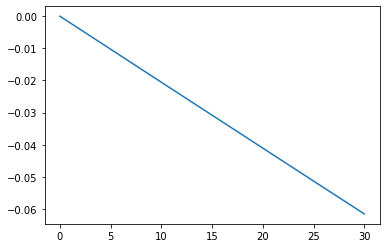

In [ ]:
plt.plot(means)

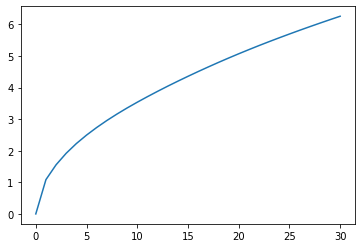

In [ ]:
plt.plot(stds)

In [ ]:
stds

[0.0,
 1.0858796465521126,
 1.556017011973598,
 1.9217677462946574,
 2.228366158793651,
 2.4953964400714703,
 2.7358125435737817,
 2.9571307584237307,
 3.162067860737714,
 3.3548281065515297,
 3.537155608454229,
 3.7120803017636343,
 3.8808702095312335,
 4.044880312115551,
 4.203159819962728,
 4.357240893877246,
 4.507623049042775,
 4.653999189174414,
 4.796852126690666,
 4.935546171850454,
 5.070954087157907,
 5.202354852476439,
 5.331115430725617,
 5.455929523510874,
 5.577672557351427,
 5.697165151141915,
 5.814317438031195,
 5.928886728694055,
 6.041188956291376,
 6.151541924601213,
 6.259825384143825]